# Machine Learning Pipeline - Interpretation

Check the python kernel we are using, should be the local one, not the one in the virtual environment

In [270]:
import sys
print(sys.executable)

/usr/bin/python3


## Import libraries

In [346]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import math
import pickle
import matplotlib.lines as mlines
import matplotlib.collections as mcollections
from collections import OrderedDict
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
from collections import Counter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Variables

In [272]:
X_train_filename = "Regression_Output/regression_X_train_red"
y_train_filename = "Regression_Output/regression_y_train_red"
bin_train_filename = "Regression_Output/regression_bin_train_red"
model_filename = "Regression_Output/regressor_final_model"

In [273]:
regr_X_train_reduced = pickle.load(open(X_train_filename,"rb"))
regr_y_train = pickle.load(open(y_train_filename,"rb"))
regr_bin_train = pickle.load(open(bin_train_filename,"rb"))
regr_model = pickle.load(open(model_filename,"rb"))

In [274]:
regr_bin_train = regr_bin_train.squeeze()

In [275]:
y_train = pd.Series(regr_y_train)

In [276]:
predictions_array = regr_model.predict(regr_X_train_reduced)
predictions_array = pd.Series(predictions_array, index = regr_bin_train.index)

In [277]:
deltas = np.abs(regr_y_train - predictions_array).astype(float)

In [278]:
rownames = ["bin", "observed", "predicted", "residual"]

In [279]:
errors_df = pd.DataFrame([regr_bin_train, regr_y_train, predictions_array, deltas], index = rownames).transpose()
errors_df["idx"] = errors_df.index; errors_df = errors_df.astype({"residual":float})

## Model Debugging

In [280]:
backbone = pd.read_csv(filepath_or_buffer= "/home/ieo7429/Desktop/THESIS_GAB/tables/backbone_1Mbp.tsv", sep = "\t", header = 0)

In [281]:
errors_df_with_coords = pd.merge(left = backbone, right = errors_df, how = "inner", on = "bin")

In [282]:
top10_worst_predictions = errors_df_with_coords.nlargest(10, "residual")

In [283]:
top10_worst_predictions

,chr,start,end,bin,observed,predicted,residual,idx
1341,chr19,22048093,23050278,19_23,-1.254008,-0.301871,0.952138,842
865,chr9,121183074,122184586,9_122,-0.613145,0.142661,0.755806,1984
1082,chr12,78499591,79505995,12_79,1.184221,0.481226,0.702995,501
1129,chr14,43140439,44143704,14_44,1.38515,0.69685,0.688300,548
673,chr7,67058425,68059296,7_68,-0.750977,-0.072969,0.678008,1809
504,chr5,15076261,16081344,5_16,0.91359,0.270516,0.643073,1565
497,chr4,188151717,189152523,4_189,-0.979604,-0.352682,0.626922,1436
268,chr3,2000227,3000339,3_3,-0.780147,-0.182756,0.597392,1284
1016,chr11,103004945,104004992,11_104,1.080942,0.485108,0.595834,311
321,chr3,95010736,96010848,3_96,1.327609,0.745272,0.582337,1341


## SHAP analysis

In [429]:
explainer = shap.TreeExplainer(regr_model, approximate= False)
shap_values = explainer(regr_X_train_reduced)

In [430]:
original_idx = regr_y_train.index.get_loc("1984")

In [431]:
shap_vals_df = pd.DataFrame(shap_values.values, columns= regr_X_train_reduced.columns)

In [432]:
cols_idxs = np.argmax(np.abs(shap_vals_df), axis = 1)

In [433]:
cols_occurrences = pd.Series(regr_X_train_reduced.columns[cols_idxs], index= regr_bin_train.index, name = "annotation")
extracted_values = pd.Series([shap_vals_df.iloc[i, cols_idxs[i]] for i in range(len(shap_vals_df))], 
                             index = regr_X_train_reduced.index, name= "associated_shap")

In [434]:
annot_with_bins = pd.concat([regr_bin_train, cols_occurrences, extracted_values], axis = 1)

In [435]:
annot_with_coords = pd.merge(left = annot_with_bins, right = backbone, how = "inner", on = "bin")
annot_with_coords = pd.merge(left = annot_with_coords, right = errors_df[["bin","predicted"]], how = "inner", on = "bin")
annot_with_coords = annot_with_coords[["bin", "chr", "start", "end", "annotation", "associated_shap", "predicted"]]

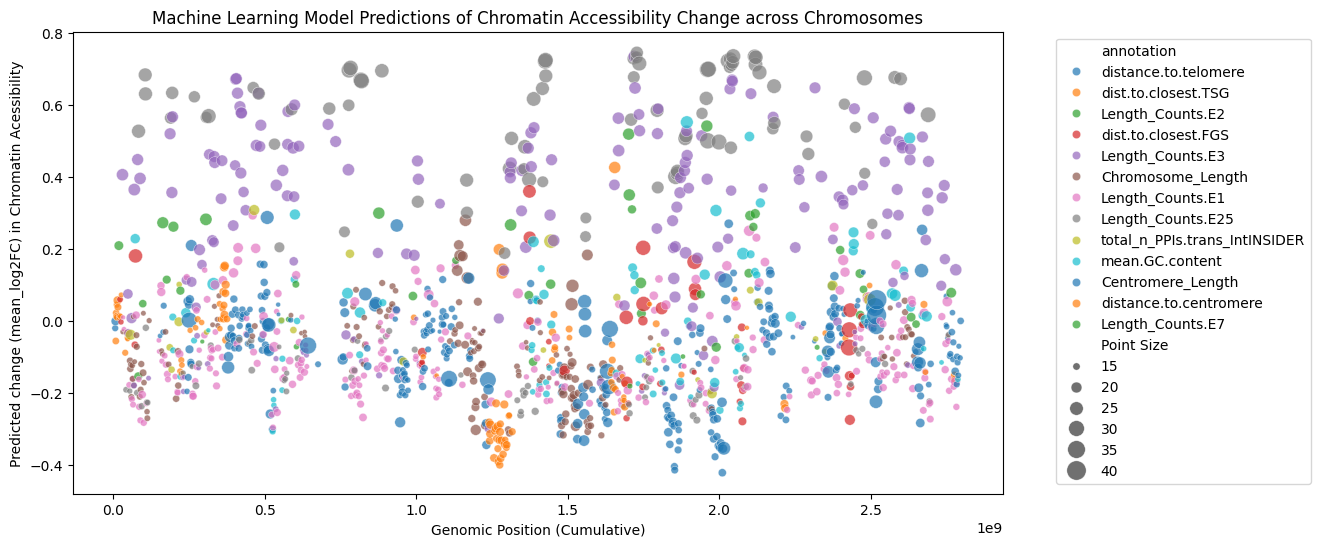

In [436]:
df = annot_with_coords.copy(deep = True)

df["midpoint"] = (df["start"] + df["end"]) / 2

df.sort_values(["chr", "start"], inplace=True)

chr_offsets = {chrom: offset for chrom, offset in zip(df["chr"].unique(), np.cumsum([0] + list(df.groupby("chr")["end"].max()[:-1])))}
df["cumulative_midpoint"] = df["midpoint"] + df["chr"].map(chr_offsets)

df["Point Size"] = (df["associated_shap"].abs() * 100) + 10

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="cumulative_midpoint",
    y="predicted",
    hue="annotation",
    size="Point Size",
    sizes=(10, 200),
    palette="tab10",
    alpha=0.7
)

plt.xlabel("Genomic Position (Cumulative)")
plt.ylabel("Predicted change (mean_log2FC) in Chromatin Acessibility")
plt.title("Machine Learning Model Predictions of Chromatin Accessibility Change across Chromosomes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## SHAP values Bimodal Trend

In [437]:
unique_classes = annot_with_coords["chr"].unique()
palette = sns.color_palette("Set2", len(unique_classes))
class_color_map = dict(zip(unique_classes, palette))

In [438]:
feature_to_zoom_into_1 = "dist.to.closest.TSG"
feature_to_zoom_into_2 = "Length_Counts.E25"

In [439]:
train_vals_1 = pd.DataFrame([regr_X_train_reduced[feature_to_zoom_into_1], regr_bin_train]).transpose()
train_vals_2 = pd.DataFrame([regr_X_train_reduced[feature_to_zoom_into_2], regr_bin_train]).transpose()

In [440]:
subset_df_1 = annot_with_coords[annot_with_coords.annotation == feature_to_zoom_into_1]; subset_df_1 = pd.merge(subset_df_1, train_vals_1, on = "bin")
subset_df_2 = annot_with_coords[annot_with_coords.annotation == feature_to_zoom_into_2]; subset_df_2 = pd.merge(subset_df_2, train_vals_2, on = "bin")

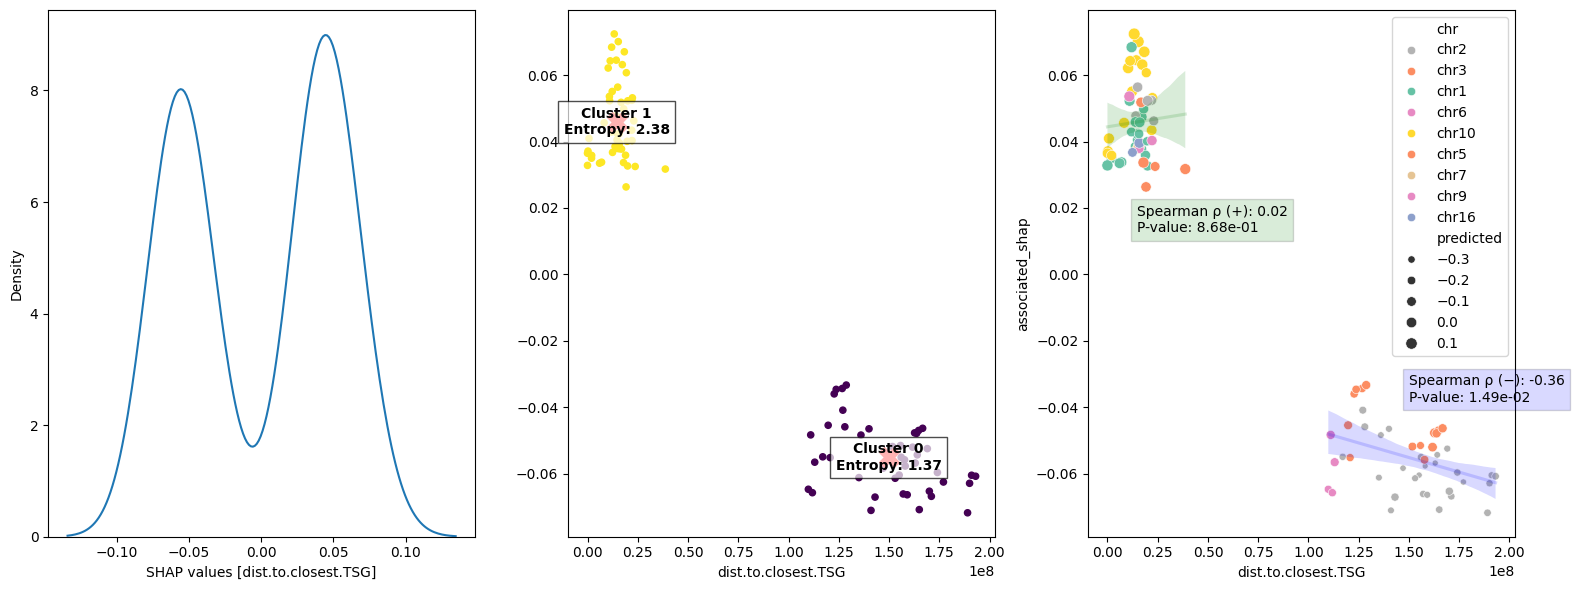

In [441]:
feature_c = "predicted"
feature_b = "associated_shap"
feature_a1 = feature_to_zoom_into_1

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

subset_df_1 = subset_df_1.drop(subset_df_1[subset_df_1.associated_shap < -0.100].index)
subset_df_1['predicted'] = pd.to_numeric(subset_df_1['predicted'], errors='coerce')
subset_df_1[feature_to_zoom_into_1] = pd.to_numeric(subset_df_1[feature_to_zoom_into_1], errors='coerce')

subset_df_1["sign"] = subset_df_1["associated_shap"].apply(lambda x: "+" if x >= 0 else "-")
subset_df_1plus = subset_df_1[subset_df_1['sign'] == '+']
subset_df_1minus = subset_df_1[subset_df_1['sign'] == '-']

res_1plus = sp.stats.spearmanr(a = subset_df_1plus[feature_a1], b = subset_df_1plus[feature_b]); statistics_1plus = res_1plus.statistic; pvalue_1plus = res_1plus.pvalue; 
res_1minus = sp.stats.spearmanr(a = subset_df_1minus[feature_a1], b = subset_df_1minus[feature_b]); statistics_1minus = res_1minus.statistic; pvalue_1minus = res_1minus.pvalue;

X1 = subset_df_1[[feature_a1,feature_b]]; X1 = X1.to_numpy()

kmeans1 = sk.cluster.KMeans(n_clusters = 2, random_state = 4843); kmeans1.fit(X1)
centers1 = kmeans1.cluster_centers_; labels1 = kmeans1.labels_

subset_df_1["cluster"] = labels1
subset_df_1["class"] = subset_df_1["chr"].apply(lambda x: x[3:])

text_1plus = f"Spearman ρ (+): {statistics_1plus:.2f}\nP-value: {pvalue_1plus:.2e}"
text_1minus = f"Spearman ρ (−): {statistics_1minus:.2f}\nP-value: {pvalue_1minus:.2e}"

# first plot
sns.kdeplot(subset_df_1.associated_shap, ax = axes[0])
axes[0].set_xlabel(f"SHAP values [{feature_to_zoom_into_1}]")

# second plot
sns.scatterplot(x = feature_a1,  y = feature_b, hue = "chr", size = feature_c, data = subset_df_1, ax= axes[2], palette = class_color_map)
sns.regplot(data = subset_df_1plus, x = feature_a1, y = feature_b, ax = axes[2], scatter=False, line_kws={'alpha': 0.15, 'color': 'green'})
sns.regplot(data = subset_df_1minus, x = feature_a1, y = feature_b, ax = axes[2], scatter=False, line_kws={'alpha': 0.15, 'color': 'blue'})
axes[2].set_xlabel(feature_a1); axes[2].set_ylabel(feature_b)
axes[2].text(centers1[1, 0] - 0.1, centers1[1, 1] - 0.025, text_1plus, transform=axes[2].transData, verticalalignment='top', fontsize=10, bbox=dict(facecolor='green', alpha=0.15))
axes[2].text(centers1[0, 0] - 0.1, centers1[0, 1] + 0.025, text_1minus, transform=axes[2].transData, verticalalignment='top', fontsize=10, bbox=dict(facecolor='blue', alpha=0.15))

# third plot
axes[1].scatter(X1[:, 0], X1[:, 1], c = labels1, cmap = 'viridis', s=20)
axes[1].scatter(centers1[:, 0], centers1[:, 1], c = 'red', marker = 'X', s=200)
axes[1].set_xlabel(feature_a1)

for i, center in enumerate(centers1):
    idxs = np.where(labels1 == i)[0]
    cluster_df = subset_df_1.iloc[idxs]
    cluster_true_labels = cluster_df["class"]
    
    total = len(cluster_true_labels)
    counts = Counter(cluster_true_labels)
    probs = [count / total for count in counts.values()]
    ent = sp.stats.entropy(probs, base=2)

    text = f"Cluster {i}\nEntropy: {ent:.2f}"
    axes[1].text(center[0], center[1], text, fontsize=10, fontweight='bold',
                 ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

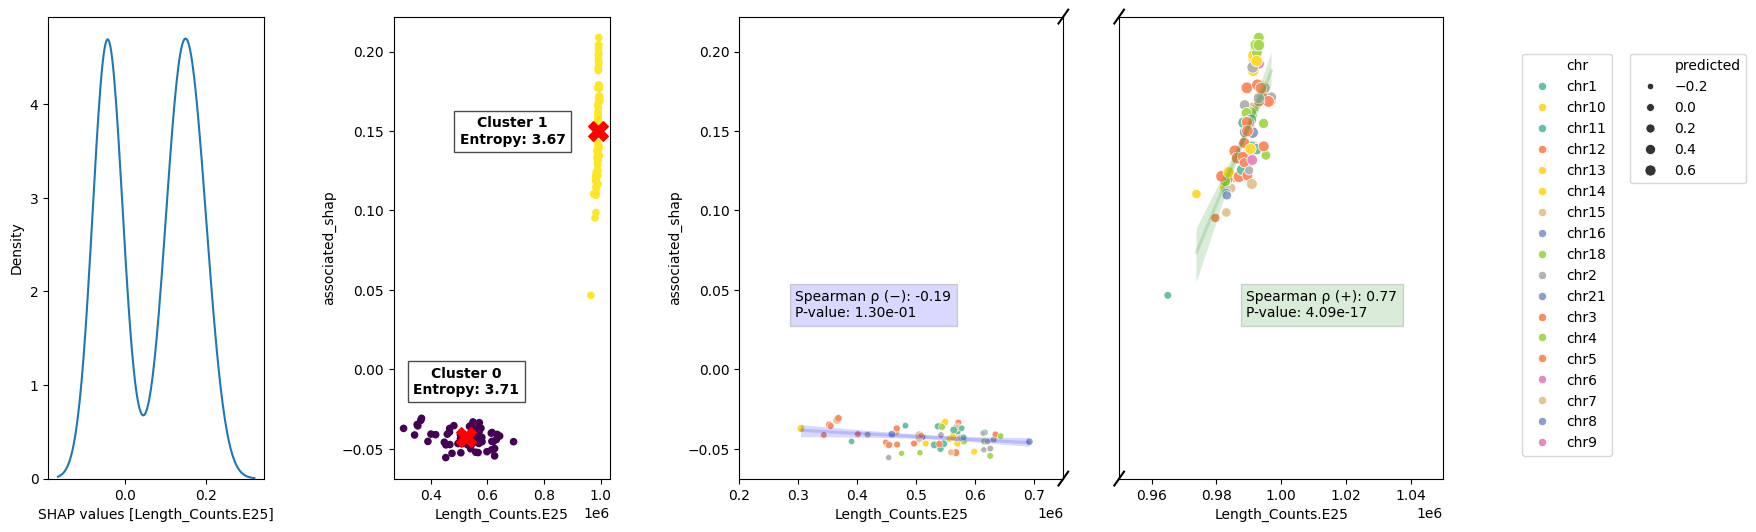

In [470]:
feature_c = "predicted"
feature_b = "associated_shap"
feature_a2 = feature_to_zoom_into_2

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

subset_df_2 = subset_df_2.drop(subset_df_2[subset_df_2.associated_shap < -0.100].index)
subset_df_2['predicted'] = pd.to_numeric(subset_df_2['predicted'], errors='coerce')
subset_df_2[feature_to_zoom_into_2] = pd.to_numeric(subset_df_2[feature_to_zoom_into_2], errors='coerce')

subset_df_2["sign"] = subset_df_2["associated_shap"].apply(lambda x: "+" if x >= 0 else "-")
subset_df_2plus = subset_df_2[subset_df_2['sign'] == '+']; subset_df_2plus = subset_df_2plus[subset_df_2plus['associated_shap'] > 0.05]
subset_df_2minus = subset_df_2[subset_df_2['sign'] == '-']

res_2plus = sp.stats.spearmanr(a = subset_df_2plus[feature_a2], b = subset_df_2plus[feature_b]); statistics_2plus = res_2plus.statistic; pvalue_2plus = res_2plus.pvalue; 
res_2minus = sp.stats.spearmanr(a = subset_df_2minus[feature_a2], b = subset_df_2minus[feature_b]); statistics_2minus = res_2minus.statistic; pvalue_2minus = res_2minus.pvalue;

X2 = subset_df_2[[feature_a2,feature_b]]; X2 = X2.to_numpy()
kmeans2 = sk.cluster.KMeans(n_clusters = 2, random_state = 4843); kmeans2.fit(X2)
centers2 = kmeans2.cluster_centers_; labels2 = kmeans2.labels_
subset_df_2["cluster"] = labels2; subset_df_2["class"] = subset_df_2["chr"].apply(lambda x: x[3:])

text_2plus = f"Spearman ρ (+): {statistics_2plus:.2f}\nP-value: {pvalue_2plus:.2e}"
text_2minus = f"Spearman ρ (−): {statistics_2minus:.2f}\nP-value: {pvalue_2minus:.2e}"

plt.close('all')

fig = plt.figure(figsize=(18, 6))  # More width for breathing room

gs = gridspec.GridSpec(1, 6, width_ratios=[1.2, 0.1, 1.2, 0.1, 1.80, 1.80])  # More even layout

ax0 = plt.subplot(gs[0])  # KDE
ax1 = plt.subplot(gs[2])  # Clustering
ax2 = plt.subplot(gs[4])  # Scatter Left
ax3 = plt.subplot(gs[5], sharey=ax2)  # Scatter Right

break_left_min = 200_000
break_left_max = 750_000
break_right_min = 950_000
break_right_max = 1_050_000

sns.kdeplot(subset_df_2.associated_shap, ax=ax0)
ax0.set_xlabel(f"SHAP values [{feature_to_zoom_into_2}]")
ax0.set_ylabel("Density")

ax1.scatter(X[:, 0], X[:, 1], c=labels2, cmap='viridis', s=20)
ax1.scatter(centers2[:, 0], centers2[:, 1], c='red', marker='X', s=200)
ax1.set_xlabel(feature_a2)
ax1.set_ylabel(feature_b)

for i, center in enumerate(centers2):
    idxs = np.where(labels2 == i)[0]
    cluster_df = subset_df_2.iloc[idxs]
    cluster_true_labels = cluster_df["class"]
    
    total = len(cluster_true_labels)
    counts = Counter(cluster_true_labels)
    probs = [count / total for count in counts.values()]
    ent = sp.stats.entropy(probs, base=2)

    text = f"Cluster {i}\nEntropy: {ent:.2f}"

    if i == 0:
        x = center[0]
        y = center[1] + 0.035
    else:
        x = center[0] - 300_000
        y = center[1]
    
    ax1.text(x, y, text, fontsize=10, fontweight='bold',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

sns.scatterplot(x=feature_a2, y=feature_b, hue="chr", size=subset_df_2["predicted"], data=subset_df_2[(subset_df_2[feature_a2] >= break_left_min) & (subset_df_2[feature_a2] <= break_left_max)], ax=ax2, palette = class_color_map, legend="brief")
sns.regplot(data=subset_df_2plus[(subset_df_2plus[feature_a2] >= break_left_min) & (subset_df_2plus[feature_a2] <= break_left_max)], x=feature_a2, y=feature_b, ax=ax2, scatter=False, line_kws={'alpha': 0.15, 'color': 'green'})
sns.regplot(data=subset_df_2minus[(subset_df_2minus[feature_a2] >= break_left_min) & (subset_df_2minus[feature_a2] <= break_left_max)], x=feature_a2, y=feature_b, ax=ax2, scatter=False, line_kws={'alpha': 0.15, 'color': 'blue'})
ax2.text(breakpoint + 50_000, 0.05, text_2minus, transform=ax3.transData, verticalalignment='top', fontsize=10, bbox=dict(facecolor='blue', alpha=0.15))
ax2.set_xlim(break_left_min, break_left_max)
ax2.set_xlabel(feature_a2)
ax2.set_ylabel(feature_b)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
ax2.get_legend().set_visible(False)

sns.scatterplot(x=feature_a2, y=feature_b, hue="chr", size=subset_df_2["predicted"], data=subset_df_2[(subset_df_2[feature_a2] >= break_right_min) & (subset_df_2[feature_a2] <= break_right_max)], ax=ax3, palette = class_color_map, legend="brief")
sns.regplot(data=subset_df_2plus[(subset_df_2plus[feature_a2] >= break_right_min) & (subset_df_2plus[feature_a2] <= break_right_max)], x=feature_a2, y=feature_b, ax=ax3, scatter=False, line_kws={'alpha': 0.15, 'color': 'green'})
sns.regplot(data=subset_df_2minus[(subset_df_2minus[feature_a2] >= break_right_min) & (subset_df_2minus[feature_a2] <= break_right_max)], x=feature_a2, y=feature_b, ax=ax3, scatter=False, line_kws={'alpha': 0.15, 'color': 'blue'})
ax3.text(centers2[1, 0] - 0.1, 0.05, text_2plus, transform=ax3.transData, verticalalignment='top', fontsize=10, bbox=dict(facecolor='green', alpha=0.15))
ax3.set_xlim(break_right_min, break_right_max)
ax3.set_xlabel(feature_a2)
ax3.set_ylabel("")
ax3.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax3.get_legend().set_visible(False)
ax3.tick_params(labelleft=False, axis='y', which='both', length=0, width=0)

d = .015
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=ax3.transAxes)
ax3.plot((-d, +d), (-d, +d), **kwargs)
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)

handles_2, labels_2 = ax2.get_legend_handles_labels()
handles_3, labels_3 = ax3.get_legend_handles_labels()

handles = list(handles_2 + handles_3)
labels = list(labels_2 + labels_3)

ordered = OrderedDict(zip(labels, handles))
chr_keys = sorted([x for x in ordered.keys() if x.startswith("c")])
pred_keys = [x for x in ordered.keys() if x not in chr_keys_sorted]

ordered_chr = {key: ordered[key] for key in chr_keys}
handles_chr, labels_chr = list(ordered_chr.values()), list(ordered_chr.keys())

ordered_pred = {key: ordered[key] for key in pred_keys}
handles_pred, labels_pred = list(ordered_pred.values()), list(ordered_pred.keys())

fig.legend(handles_chr, labels_chr, ncol = 1, loc='upper left', bbox_to_anchor=(0.94, 0.83), fontsize=10)
fig.legend(handles_pred, labels_pred, ncol = 1, loc='upper left', bbox_to_anchor=(1, 0.83), fontsize=10)

fig.subplots_adjust(wspace=0.3)

plt.show()